In [1]:
import re
import os
import numpy as np
import scipy.interpolate as interp
from scipy.ndimage import map_coordinates

from robotcar.python.camera_model import CameraModel
from robotcar.python.transform import build_se3_transform
from robotcar.python.image import load_image
from robotcar.python.interpolate_poses import interpolate_vo_poses, interpolate_ins_poses

from PIL import Image

import matplotlib.pyplot as plt

import cv2

### Directories

In [2]:
image_dir = 'data/robotcar/sample/stereo/left/'
extrinsics_dir = 'robotcar/extrinsics/'
models_dir = 'robotcar/models/'
lidar_dir = 'data/robotcar/sample/ldmrs/'

vo_poses_file = ''
ins_poses_file = 'data/robotcar/sample/gps/ins.csv'

#### Which image(s)

In [3]:
img_index = 10

### Camera Extrinsics

In [4]:
model = CameraModel(models_dir, image_dir)

extrinsics_path = os.path.join(extrinsics_dir, model.camera + '.txt')
with open(extrinsics_path) as extrinsics_file:
    extrinsics = [float(x) for x in next(extrinsics_file).split(' ')]

G_camera_vehicle = build_se3_transform(extrinsics)

### Build Pointclouds for VO and INS

In [5]:
# Timestamps for Pointcloud Generation
start_time = 1418381798113072
end_time = 1418381817070979

In [6]:
lidar = re.search('(lms_front|lms_rear|ldmrs)', lidar_dir).group(0)
timestamps_path = os.path.join(lidar_dir, os.pardir, lidar + '.timestamps')

timestamps = []
with open(timestamps_path) as timestamps_file:
    for line in timestamps_file:
        timestamp = int(line.split(' ')[0])
        if start_time <= timestamp <= end_time:
            timestamps.append(timestamp)

if len(timestamps) == 0:
    raise ValueError("No LIDAR data in the given time bracket.")


### Process Image(s)

In [7]:
timestamps_path = os.path.join(image_dir, os.pardir, model.camera + '.timestamps')
if not os.path.isfile(timestamps_path):
    timestamps_path = os.path.join(image_dir, os.pardir, os.pardir, model.camera + '.timestamps')

with open(timestamps_path) as timestamps_file:
    for i, line in enumerate(timestamps_file):
        if i == img_index:
            timestamp_img = int(line.split(' ')[0])
            
image_path = os.path.join(image_dir, str(timestamp_img) + '.png')
image = load_image(image_path, model)

#### VO Pointcloud

In [8]:
# sensor is VO, which is located at the main vehicle frame
with open(os.path.join(extrinsics_dir, lidar + '.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
G_posesource_laser = build_se3_transform([float(x) for x in extrinsics.split(' ')])

poses = interpolate_vo_poses(vo_poses_file, timestamps, timestamp_img)

pointcloud_vo = np.array([[0], [0], [0], [0]])

for i in range(0, len(poses)):
    scan_path = os.path.join(lidar_dir, str(timestamps[i]) + '.bin')
    if not os.path.isfile(scan_path):
        continue

    scan_file = open(scan_path)
    scan = np.fromfile(scan_file, np.double)
    scan_file.close()
    scan = scan.reshape((len(scan) // 3, 3)).transpose()
    scan = np.dot(np.dot(poses[i], G_posesource_laser), np.vstack([scan, np.ones((1, scan.shape[1]))]))
    pointcloud_vo = np.hstack([pointcloud_vo, scan])

pointcloud_vo = pointcloud_vo[:, 1:]
pointcloud_vo = np.dot(G_camera_vehicle, pointcloud_vo)

IOError: [Errno 2] No such file or directory: ''

#### GPS INS Pointcloud

In [20]:
with open(os.path.join(extrinsics_dir, 'ins.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
    G_posesource_laser = np.linalg.solve(build_se3_transform([float(x) for x in extrinsics.split(' ')]),
                                         G_posesource_laser)
    G_camera_posesource = G_camera_vehicle * build_se3_transform([float(x) for x in extrinsics.split(' ')])
    
poses = interpolate_ins_poses(ins_poses_file, timestamps, timestamp_img)

pointcloud_ins = np.array([[0], [0], [0], [0]])

for i in range(0, len(poses)):
    scan_path = os.path.join(lidar_dir, str(timestamps[i]) + '.bin')
    if not os.path.isfile(scan_path):
        continue

    scan_file = open(scan_path)
    scan = np.fromfile(scan_file, np.double)
    scan_file.close()
    scan = scan.reshape((len(scan) // 3, 3)).transpose()
    scan = np.dot(np.dot(poses[i], G_posesource_laser), np.vstack([scan, np.ones((1, scan.shape[1]))]))
    pointcloud_ins = np.hstack([pointcloud_ins, scan])

pointcloud_ins = pointcloud_ins[:, 1:]
pointcloud_ins = np.dot(G_camera_posesource, pointcloud_ins)

#### Sparse Local Pointcloud

In [10]:
lidar = re.search('(lms_front|lms_rear|ldmrs)', lidar_dir).group(0)
timestamps_path = os.path.join(lidar_dir, os.pardir, lidar + '.timestamps')

#timestamps = []
with open(timestamps_path) as timestamps_file:
    for line in timestamps_file:
        this_timestamp = int(line.split(' ')[0])
        if this_timestamp >= timestamp_img:
            timestamp_lidar = this_timestamp
            break

            
            
with open(os.path.join(extrinsics_dir, lidar + '.txt')) as extrinsics_file:
    extrinsics = next(extrinsics_file)
G_posesource_laser = build_se3_transform([float(x) for x in extrinsics.split(' ')])

local_pointcloud = np.array([[0], [0], [0], [0]])

scan_path = os.path.join(lidar_dir, str(timestamp_lidar) + '.bin')

scan_file = open(scan_path)
scan = np.fromfile(scan_file, np.double)
scan_file.close()

scan = scan.reshape((len(scan) // 3, 3)).transpose()

scan = np.dot(G_posesource_laser, np.vstack([scan, np.ones((1, scan.shape[1]))]))
local_pointcloud = np.hstack([local_pointcloud, scan])

local_pointcloud = local_pointcloud[:, 1:]
local_pointcloud = np.dot(G_camera_vehicle, local_pointcloud)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.


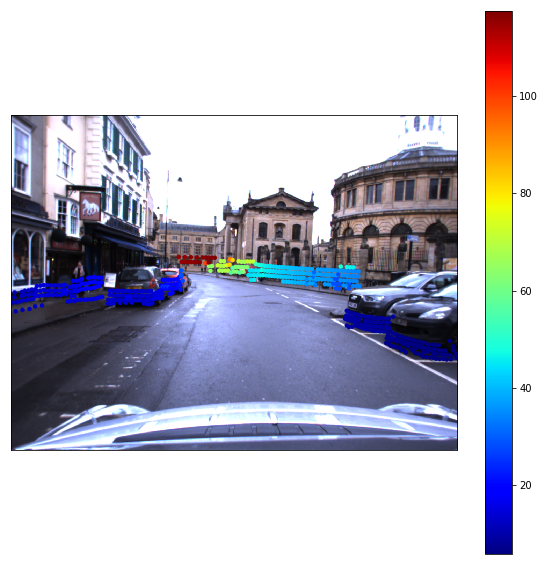

In [44]:
uv, depth = model.project(local_pointcloud, image.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=depth, edgecolors='none', cmap='jet')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])
plt.savefig('projected.png')
plt.show()



In [12]:
img = load_image(image_path)
img = Image.fromarray(img)
img.save("test_images/test.png")

In [13]:
!python monodepth/monodepth_simple.py --image_path test_images/test.png --checkpoint_path monodepth/model_kitti/model_kitti.ckpt

2018-02-09 16:44:27.462221: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
done!


In [21]:
pred_disparities = np.load('test_images/test_disp.npy')

def convert_disps_to_depths(pred_disp, height, width):

    pred_disp = width * cv2.resize(pred_disp, (width, height), interpolation=cv2.INTER_LINEAR)

    pred_depths = 983.044006 * 0.24 / pred_disp
    
    return pred_depths
pred_depth = convert_disps_to_depths(pred_disparities, 960, 1280)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app


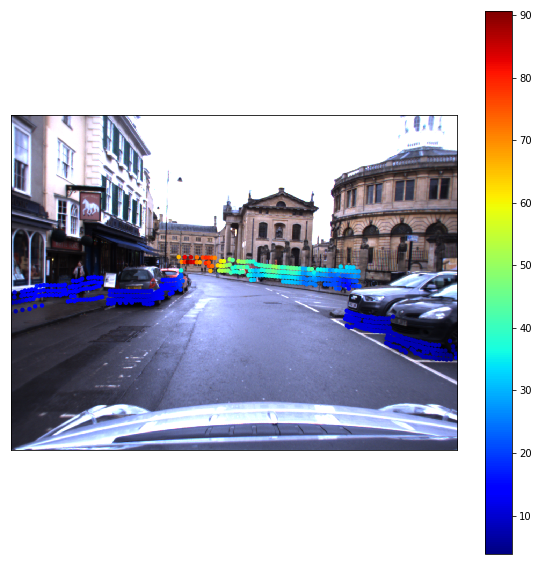

In [45]:
# pred_depth
# 960 x 1200

pixels = np.array(uv.transpose())
# 1200 x 960

pred_depth_pixels = []

for pixel in pixels:
    pred_depth_pixels.append(pred_depth[int(round(pixel[1]))][int(round(pixel[0]))])
    
uv, depth = model.project(local_pointcloud, image.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=pred_depth_pixels, edgecolors='none', cmap='jet')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])
plt.savefig('projected.png')
plt.show()

## Show Error Magnitude

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  


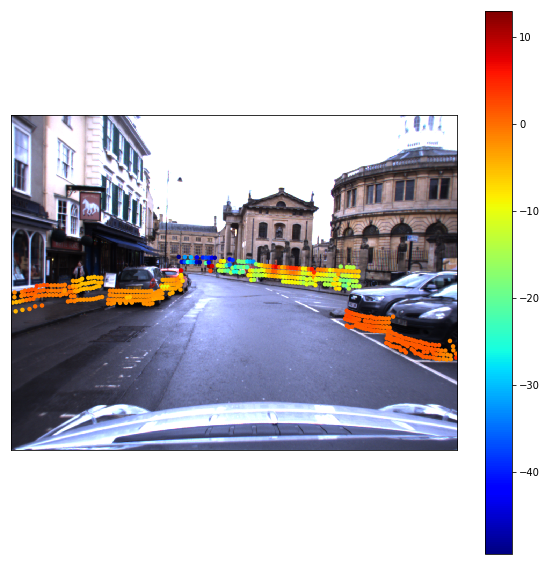

In [43]:
pixels = np.array(uv.transpose())
# 1200 x 960

pred_depth_pixels = []

i = 0
for pixel in pixels:
    pred_depth_pixels.append(pred_depth[int(round(pixel[1]))][int(round(pixel[0]))] - depth[i])
    i += 1
    
uv, depth = model.project(local_pointcloud, image.shape)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.hold(True)
sc = plt.scatter(np.ravel(uv[0, :]), np.ravel(uv[1, :]), s=20, c=pred_depth_pixels, edgecolors='none', cmap='jet')
plt.colorbar(sc)
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.xticks([])
plt.yticks([])
plt.savefig('projected.png')
plt.show()

11.699771939543187


In [14]:
def compute_errors(gt_depths, pred_depths):
    gt = []
    pred = []
    for t in gt_depths:
        gt.append(t[2])
        pred.append(pred_depths[int(t[1])-1][int(t[0])-1])
    gt = np.array(gt)
    pred = np.array(pred)
    #thresh = np.maximum((gt / pred), (pred / gt))
    #a1 = (thresh < 1.25   ).mean()
    #a2 = (thresh < 1.25 ** 2).mean()
    #a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred)**2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log

In [18]:
gt_depth = np.asarray(np.vstack((uv, depth)).transpose())

In [19]:
compute_errors(gt_depth, pred_depth)

(0.1948094076384855,
 1.7290602426482407,
 10.228240745138102,
 0.25764214518678036)